In [1]:
"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Python packages
"""

import numpy as np
from scipy import stats, optimize
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Union

"""
Own packages
"""

import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

from codelib.visualization.layout import DefaultStyle, default_colors
DefaultStyle();

from codelib.visualization.base import fan_chart

# moments 
from codelib.statistics.moments import weighted_percentile

# Views
from codelib.statistics.fully_flexible_views import ProbabilitySolver, MeanView, VolatilityView
from codelib.statistics.fully_flexible_views import effective_sample_size_entropy

# Fully Flexible Views

## Entropy minimization 

[Attilio Meucci (2010), Fully Flexible Views: Theory and Practice](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1213325) presents how we can incorporate views on all moments such as the mean, standard devation and correlation. The views are applicable even in non-normal markets where we cannot implement the Black-Litterman framework.  The starting point is a reference / prior distribution of the random variables $\mathbf{X}$, e.g. asset returns, 

$$
\mathbf{X} \sim f_\mathbf{X}
$$

The approach applies Relative Entropy Minimization (REM). The goal is to find a distribution that satisfies our views while being as close as possible to the prior distribution. Closeness is quantified by the [relative entropy](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence): 

$$
\mathcal{E} (\tilde{f}_{\mathbf{X}}, f_{\mathbf{X}}) = \intop \tilde{f}_{\mathbf{X}} \left[\ln \tilde{f}_{\mathbf{X}} - \ln f_{\mathbf{X}}  \right] d\mathbf{x}
$$

where $f_{\mathbf{X}}$ is the reference / prior distribution and  $\tilde{f}_{\mathbf{X}}$ is a generic distribution which aligns with our view. 

So basically, we need to minimize the relative entropy

$$
\tilde{f}_{\mathbf{X}} \equiv \underset{f \in \mathbb{V}}{\text{arg min }} \mathcal{E} (f, f_{\mathbf{X}})
$$

where $f \in \mathbb{V}$ stands for all the distributions consistent with the views. We will label the solution to the above minimization problem as the full confidence posterior (the views will be satisfied). 

__Example: Plotting the relative entropy__

To get a better feeling of the relative entropy, we will assume that we have a "prior" distribution 

$$
X \sim  N(0, 1)
$$

and a "view" distribution

$$
Y  \sim N(0.5, 1)
$$

First, we plot the two density functions 

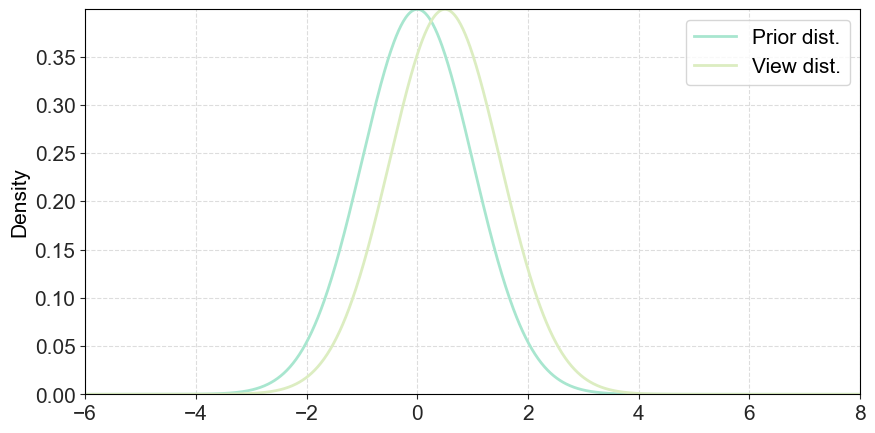

In [2]:
mu_prior = 0
sigma_prior = 1

mu_view = 0.5
sigma_view = 1

eval_values = np.linspace(-6, 8, 1000)
prior_pdf = stats.norm.pdf(eval_values, mu_prior, sigma_prior)
view_pdf = stats.norm.pdf(eval_values, mu_view, sigma_view)

"""
Plottting
"""

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(eval_values, prior_pdf, label='Prior dist.')
ax.plot(eval_values, view_pdf, label='View dist.')
ax.legend(fontsize=15);
ax.set_ylabel('Density', size=15);

Next, we plot the cumulative relative entropy. 

In [3]:
log_pdf_diff = lambda x: stats.norm.logpdf(x, mu_view, sigma_view) -  stats.norm.logpdf(x, mu_prior, sigma_prior)
entropy_eval = np.linspace(-6, 8, 100)
cum_entropy = [stats.norm.expect(log_pdf_diff, args=(), loc=mu_view, scale=sigma_view, lb=-np.inf, ub=_)
               for _ in entropy_eval]

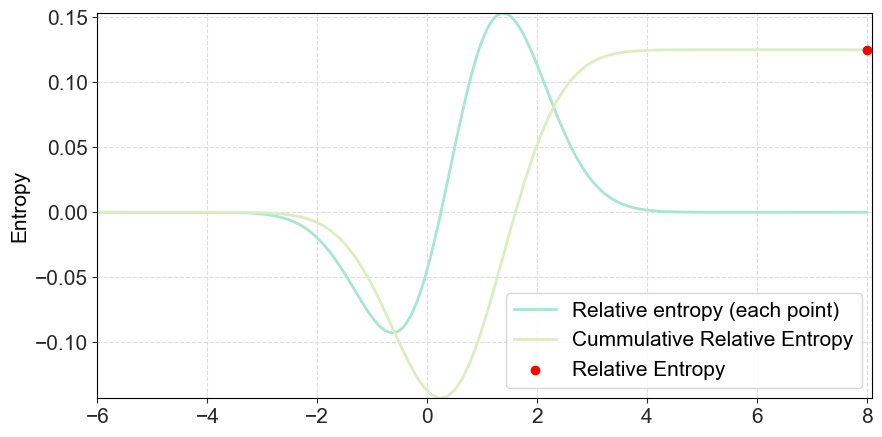

In [4]:
"""
Plotting
"""

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(eval_values, view_pdf * log_pdf_diff(eval_values), label='Relative entropy (each point)')
ax.plot(entropy_eval, cum_entropy, label='Cummulative Relative Entropy')
ax.scatter(entropy_eval[-1], cum_entropy[-1],color="red", zorder=5, label="Relative Entropy")
ax.legend(fontsize=15);
ax.set_ylabel('Entropy', size=15);
ax.set_xlim([-6, 8.1]);

The objective will be to minimize the value represented by the red dot (the total relative entropy) while our view is satisfied. 

### Confidence

Minimizing the relative entropy will give us the full confidence posterior $\tilde{f}_{\mathbf{X}}$. However, if we do not assign full confidence, then we shrink the posterior distribution towards the reference distribution using opinion-pooling
$$
\tilde{f}_{\mathbf{X}}^c = (1-c) f_{\mathbf{X}} + c \tilde{f}_{\mathbf{X}}
$$
with $c\in [0, 1]$. 

In a multiple portfolio manager context where each portfolio manager has full confidence in their views, we may find the posterior distribution as the confidence weighted average

$$
\tilde{f}_{\mathbf{X}}^c = \sum_{s=1}^S c_s \tilde{f}_{\mathbf{X}}^s
$$

## The normal case: An analytical formula for linear constraints

Generally, minimizing the relative entropy analytically is a daunting task and must therefore often be done numerically (more about this later). However, [Attilio Meucci (2010), Fully Flexible Views: Theory and Practice](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1213325) derives an analytical formula in the case where the prior distribution is normal and where the views are defined as linear transformations. 

If we assume that the prior or reference distribution of the vector random variable $\mathbf{X}$ is given by

$$
\mathbf{X} \sim N(\mu, \Sigma)
$$

and express views on expectations of linear combinations $\mathbf{Q}\mathbf{X}$ and on the covariance of arbitrary, potentially different linear combinations $\mathbf{G}\mathbf{X}$ such that 

$$
\begin{align}
\tilde{\text{E}}[\mathbf{Q}\mathbf{X}] &\equiv \tilde{\mu}_Q \\
\tilde{\text{Cov}}[\mathbf{G}\mathbf{X}] &\equiv \tilde{\Sigma}_G
\end{align}
$$

The full-confidence posterior distribution is also normal 

$$
\mathbf{X} \sim N(\tilde{\mu}, \tilde{\Sigma})
$$

where 

$$
\begin{align}
\tilde{\mu} &\equiv \mu + \Sigma \mathbf{Q}^\top \left( \mathbf{Q} \Sigma \mathbf{Q}^\top\right)(\tilde{\mu}_Q - \mathbf{Q}\mu)\\
\tilde{\Sigma} &\equiv \Sigma + \Sigma \mathbf{G}^\top \left((\mathbf{G}\Sigma \mathbf{G}^\top)^{-1} \tilde{\Sigma}_G (\mathbf{G}\Sigma \mathbf{G}^\top)^{-1}  - (\mathbf{G}\Sigma \mathbf{G}^\top)^{-1} \right) \mathbf{G} \Sigma
\end{align}
$$


__Example: Bivariate normal__

Assume that 

$$
\begin{bmatrix} x_1 \\ x_2 \end{bmatrix} \sim N\left(\begin{bmatrix} 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 1 & 0.8\\
0.8 & 1\end{bmatrix} \right)
$$

Implement the view $\text{E}[X_1] = 0.5$ and $\text{Sd}[X_1] = 0.1$. 

In [5]:
def calculate_mu_tilde(mu: np.ndarray, cov_mat: np.ndarray,
                       mu_view: np.ndarray, q_matrix: np.ndarray) -> np.ndarray: 
    
    """
    Calculates the posterior expected values with an arbitrary linear combination E[QX] = mu_view, 
    when prior distribution is assumed normal N(mu, Sigma). 
    
    Parameters
    ----------
    mu: 
        Expected value vector of prior distribution.
    cov_mat:
        Covariance matrix of prior distribution.
    mu_view: 
        Expected values of the linear combinations QX.
    q_matrix: 
        Matrix defining the linear combinations.
        
    Returns
    -------
    np.ndarray
        Expected value of the posterior distribution. 
    
    """
    
    mu_view = np.atleast_1d(mu_view)
    q_mat = np.atleast_2d(q_matrix) 
    q_mat_t = np.transpose(q_mat)
    
    mu_tilde = mu + cov_mat @ q_mat_t @ (q_mat @ cov_mat @ q_mat_t) @ (mu_view - q_mat @ mu)
    
    return mu_tilde


def calculate_sigma_tilde(cov_mat: np.array, cov_mat_view: np.array, g_matrix: np.array) -> np.ndarray: 
    
    """
    Calculates the posterior covariance matrix with the linear view Cov[GX] = cov_mat_view, when prior distribution 
    is assumed normal N(mu, Sigma). 
    
    Parameters
    ----------
    cov_mat:
        Covariance matrix of prior distribution.
    cov_mat_view: 
        Covariance of the linear combinations GX.
    g_matrix: 
        Matrix defining the linear combinations.
        
    Returns
    -------
    np.ndarray
        Covariance matrix of the posterior distribution. 
    
    """
    
    cov_mat_view = np.atleast_1d(cov_mat_view)
    
    g_mat = np.atleast_2d(g_matrix)
    g_mat_t = np.transpose(g_mat)
    
    gcovg_inv = np.linalg.inv(g_mat @ cov_mat @ g_mat_t)
    
    sigma_tilde = cov_mat + cov_mat @ g_mat_t @ (gcovg_inv @ cov_mat_view @ gcovg_inv - gcovg_inv) @ g_mat @ cov_mat
    
    return sigma_tilde

In [6]:
"""
Define input parameters
"""

# prior / reference distribution 
mu = np.array([0.0, 0.0])
cov_mat = np.array([[1.0, 0.8],
                    [0.8, 1.0]])

# mean views
q_mat = np.array([1.0, 0.0])
mu_view = np.array([0.5])

# variance views
g_mat = np.array([1.0, 0.0])
cov_mat_view = 0.01

In [7]:
"""
Calculate parameters of posterior distribution
"""

mu_tilde = calculate_mu_tilde(mu, cov_mat, mu_view, q_mat)
sigma_tilde = calculate_sigma_tilde(cov_mat, cov_mat_view, g_mat)

In [8]:
mu_tilde

array([0.5, 0.4])

In [9]:
sigma_tilde

array([[0.01  , 0.008 ],
       [0.008 , 0.3664]])

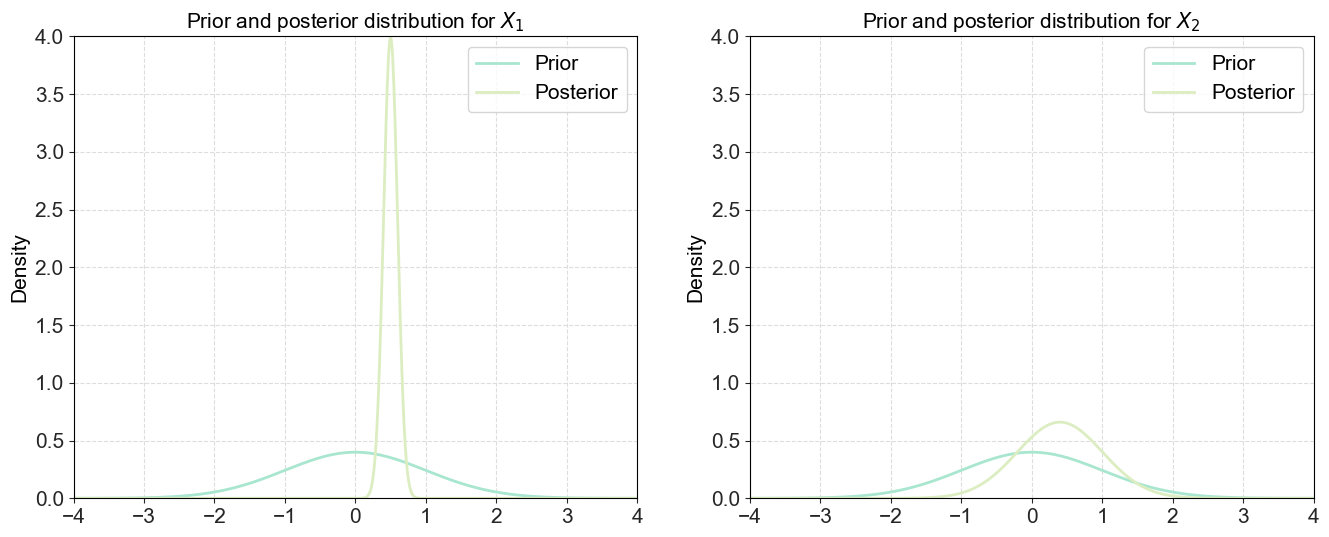

In [10]:
x_values = np.linspace(-4, 4, 1000)
norm_pdf_values = stats.norm.pdf(x_values)

fig, ax = plt.subplots(1,2, figsize=(16,6))

ax[0].plot(x_values, norm_pdf_values, label="Prior")
ax[0].plot(x_values, stats.norm.pdf(x_values, loc=mu_tilde[0], scale=np.sqrt(sigma_tilde[0,0])), label="Posterior")
ax[0].legend(fontsize=15);
ax[0].set_title('Prior and posterior distribution for $X_1$', size=15);
ax[0].set_ylabel('Density', size=15);
ax[0].set_ylim([0.0, 4.0])

ax[1].plot(x_values, norm_pdf_values, label="Prior")
ax[1].plot(x_values, stats.norm.pdf(x_values, loc=mu_tilde[1], scale=np.sqrt(sigma_tilde[1, 1])), label="Posterior");
ax[1].legend(fontsize=15);
ax[1].set_title('Prior and posterior distribution for $X_2$', size=15);
ax[1].set_ylabel('Density', size=15);
ax[1].set_ylim([0.0, 4.0]);

if False:

    plt.tight_layout()
    plt.savefig('fully_flexible_views_bivariate_normal.png', dpi=300)

__Assigning confidence__

Above, we have shown the full confidence posterior. However, if we do not assign full confidence, then we may use

$$
\tilde{f}_{\mathbf{X}}^c = (1-c) f_{\mathbf{X}} + c \tilde{f}_{\mathbf{X}}
$$
with $c\in [0, 1]$. 

Since we are considering multivariate normal distributions, then 

$$
\tilde{f}_{\mathbf{X}}^c = (1-c) \phi(\mu, \Sigma) + c \phi(\tilde{\mu}, \tilde{\Sigma}) 
$$

where $\phi(\mu, \Sigma)$ denotes the density of the multivariate normal distribution. Below we plot the posterior distribution for different confidence levels. 

In [11]:
def posterior_density_univariate(x: Union[float, np.ndarray], confidence: float, mu: float, sigma: float,
                                 mu_view: float, sigma_view: float):
    
    """
    Calculates the marginal density after applying views and at a given confidence level
    
    Parameters
    ----------
    x: 
        Value to evaluate the pdf at
    confidence: 
        Confidence that we assign to the views. 
    mu: 
        Expected value of prior distribution. 
    sigma: 
        Std. of prior distribution. 
    mu_view: 
        Expected value of full confidence view distribution. 
    sigma_view: 
        Std. of full confidence view distribution. 
    
    """
    
    return (1 - confidence) * stats.norm.pdf(x, mu, sigma) + confidence * stats.norm.pdf(x, mu_view, sigma_view) 

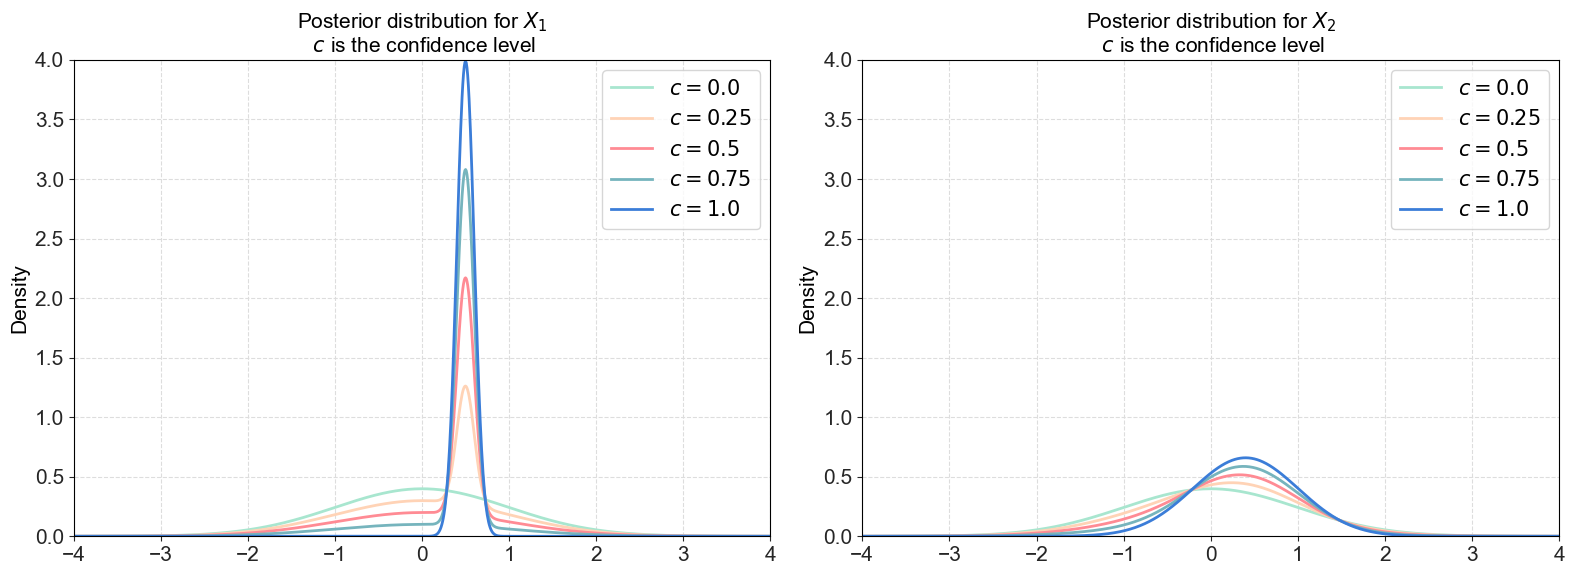

In [12]:
x_values = np.linspace(-4, 4, 1000)
confidence_levels = [0.0, 0.25, 0.5, 0.75, 1.0]

plot_colors = [default_colors[col] for col in ['green', 'orange', 'red', 'cyan', 'dark_blue']]

fig, ax = plt.subplots(1,2, figsize=(16,6))
for i, c in enumerate(confidence_levels): 
    post_pdf_values = posterior_density_univariate(x_values, c, mu[0], np.sqrt(cov_mat[0,0]),
                                                   mu_tilde[0], np.sqrt(sigma_tilde[0,0]))
    ax[0].plot(x_values, post_pdf_values, label="$c={}$".format(c), color=plot_colors[i])
    ax[0].legend(fontsize=15);
    ax[0].set_title('Posterior distribution for $X_1$\n $c$ is the confidence level', size=15);
    ax[0].set_ylabel('Density', size=15);
    ax[0].set_ylim([0.0, 4.0])

for i, c in enumerate(confidence_levels):
    post_pdf_values = posterior_density_univariate(x_values, c, mu[1], np.sqrt(cov_mat[1,1]),
                                                   mu_tilde[1], np.sqrt(sigma_tilde[1,1]))
    ax[1].plot(x_values, post_pdf_values, label="$c={}$".format(c),color=plot_colors[i])
    ax[1].legend(fontsize=15);
    ax[1].set_title('Posterior distribution for $X_2$\n $c$ is the confidence level', size=15);
    ax[1].set_ylabel('Density', size=15);
    ax[1].set_ylim([0.0, 4.0])

if True:
    plt.tight_layout()
    plt.savefig('fully_flexible_views_bivariate_normal_with_different_confidence.png', dpi=300)

## Numerical implementation using simulations 

[Attilio Meucci (2010), Fully Flexible Views: Theory and Practice](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1213325) shows how we easily can implement views on any distribution by using a (large) panel of simulations as the reference model. Basically, we are using the empirical distribution function of the simulated data as the probability function of interest. 

We seek to represent the market $\mathbf{X}$ using a $J \times N$ panel of simulations, $\mathcal{X}$, and a $J \times 1$ vector, $\mathbf{p}$, of probabilities where $J$ refers to the number of simulations and $N$ refers to the number of variables. The entries of $\mathbf{p}$ representing the prior model will often all be equal to $1 / J $, but this is not a requirement. 

We will express constraints on generic non-linear functions of the market and we will gather them in a $J \times K$ panel $\mathcal{V}$ with entries defined as 

$$
\mathcal{V}_{j,k} \equiv g_k\left(\mathcal{X}_{j,1}, ..., \mathcal{X}_{j,N} \right)
$$

To find the posterior distribution $\tilde{\mathbf{p}}$ we need to minimize the relative entropy (now a discrete version)

$$
\mathcal{E}(\tilde{\mathbf{p}}, \mathbf{p}) \equiv \sum_{j=1}^J \tilde{p}_j [\ln \tilde{p}_j  - \ln p_j ]
$$

given our views. Following Attilio Meucci (2010) we note that it will be possible to implement large number of views using linear constraints on the yet to be determined probabilities

$$
\mathbf{b} \leq \mathbf{A} \tilde{\mathbf{p}} \leq \mathbf{c} 
$$

where $\mathbf{A}$, $\mathbf{b}$ and $\mathbf{c}$ are simple expression of $\mathcal{V}$. Notably, we can implement views on expectations using $\mathbf{A} = \mathcal{V}^\top$ and $\mathbf{b}=\mathbf{c}$. 

__Example: Bivariate normal__

Again, we assume that 

$$
\begin{bmatrix} X_1 \\ X_2 \end{bmatrix} \sim N\left(\begin{bmatrix} 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 1 & 0.8\\
0.8 & 1\end{bmatrix} \right)
$$

How can we represent the views $\text{E}[X_1] = 0.5$ and $\text{Sd}[X_1] = 0.1$?

First, we let $J=10000$ and note that $N=2$. We can simply simulate the reference / prior model and represent it using the empirical distribution function. 

In [13]:
mu = np.array([0.0, 0.0])
cov_mat = np.array([[1.0, 0.8],
                    [0.8, 1.0]])

num_sim = 10000
prior_data = np.random.multivariate_normal(mu, cov_mat, size=num_sim)
init_probs = np.repeat(1.0 / num_sim, num_sim)

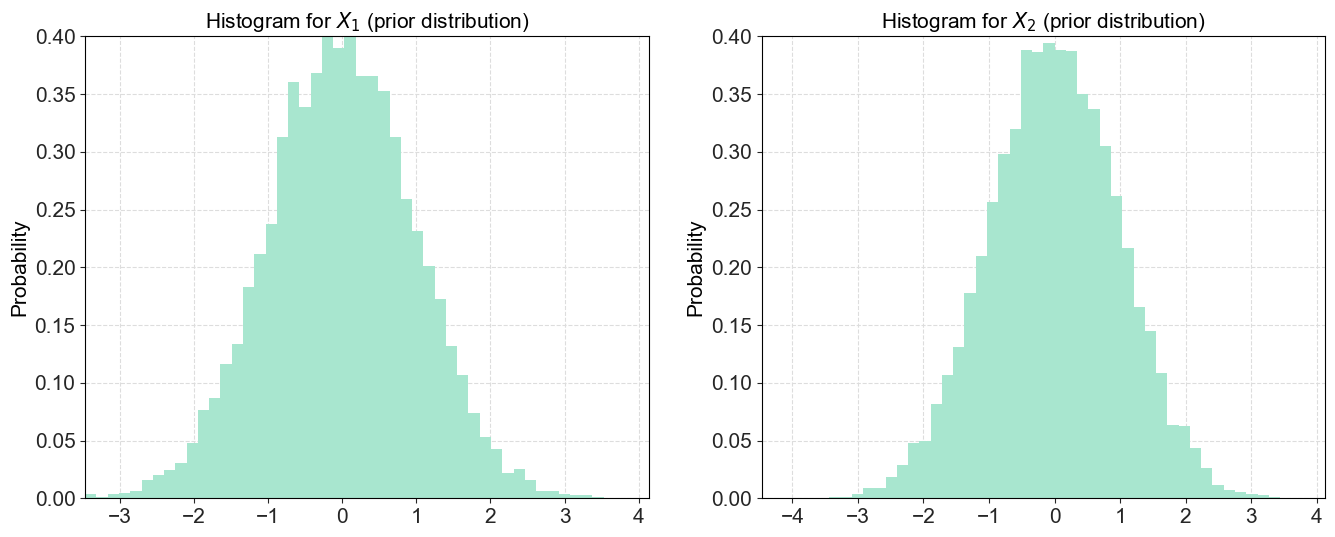

In [14]:
fig, ax = plt.subplots(1,2, figsize=(16,6))

for i in range(2):
    ax[i].hist(prior_data[:, i], bins=50, density=True)
    ax[i].set_title('Histogram for $X_{}$ (prior distribution)'.format(i + 1), size=15)
    ax[i].set_ylabel('Probability', size=15);
    ax[i].set_ylim([0.0, 0.4]);

We want to implement the two views $\text{E}[X_1] = 0.5$ and $\text{Sd}[X_1] = 0.1$. The first view can expressed simply as 

$$
\mathbf{x}_1^\top \tilde{\mathbf{p}} = \sum_{j=1}^J x_{1j} \tilde{p}_i = 0.5
$$

and the view on standard deviation can be expressed as (note that $\text{Var}[X] = \text{E}[X^2] - \text{E}[X]^2$)

$$
[\mathbf{x}_1 \odot \mathbf{x}_1]^\top \tilde{\mathbf{p}} = \sum_{j=1}^J x_{1j}^2 \tilde{p}_i = 0.1^2 + 0.5^2
$$

### A simple and computationally efficient algorithm 

[Attilio Meucci (2010), Fully Flexible Views: Theory and Practice](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1213325) suggests a simple and efficient algorithm for solving the constrained minimization problem

$$
\tilde{\mathbf{p}} = \underset{\mathbf{F} \mathbf{x} \leq \mathbf{f} \\ \mathbf{H} \mathbf{x} =\mathbf{h}}{\text{arg min}} \sum_{j=1}^J x_j [\ln x_j - \ln p_j]
$$

Note the small change of notation as the constraints representing the views have been split up into equality and inequality constraints. Furthermore, the constraint $\mathbf{x} \geq \mathbf{0}$ (probabilites equal or larger than zero) is not included since it automatically will be satisfied.

The Lagrangian for this problem read 

$$
\mathcal{L} = \mathbf{x}^\top [\ln \mathbf{x} - \ln \mathbf{p}]  + \boldsymbol{\lambda}^\top [\mathbf{F} \mathbf{x} - \mathbf{f}]+ \boldsymbol{\nu}^\top [\mathbf{H} \mathbf{x} - \mathbf{h}]
$$

where  $\boldsymbol{\lambda}$ and $\boldsymbol{\nu}$ are vectors of Lagrange multipliers. The first order conditions are given by 

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{x}} = \ln \mathbf{x} - \ln \mathbf{p} + 1 + \mathbf{F}^\top \boldsymbol{\lambda} + \mathbf{H}^\top \boldsymbol{\nu} = \mathbf{0} 
$$

It follows directly that 

$$
\mathbf{x}(\boldsymbol{\lambda}, \boldsymbol{\nu}) = e^{\ln \mathbf{p} - 1 - \mathbf{F}^\top \boldsymbol{\lambda} - \mathbf{H}^\top \boldsymbol{\nu}} \geq \mathbf{0}
$$

The [Lagrange dual function](https://en.wikipedia.org/wiki/Duality_(optimization)) is then given by 

$$
\mathcal{G}(\boldsymbol{\lambda}, \boldsymbol{\nu}) =  \mathcal{L}(\mathbf{x}(\boldsymbol{\lambda}, \boldsymbol{\nu}) , \boldsymbol{\lambda}, \boldsymbol{\nu})
$$

and the optimization problem can be restated as 

$$
\boldsymbol{\lambda}^*, \boldsymbol{\nu}^* = \underset{\boldsymbol{\lambda} \geq 0, \boldsymbol{\nu}}{\text{arg max }} \mathcal{G}(\boldsymbol{\lambda}, \boldsymbol{\nu}) 
$$

since the optimal Lagrange multipliers follow from maximization of the Lagrange dual function. Finally, we can calculate 

$$
\tilde{\mathbf{p}} = \mathbf{x}(\boldsymbol{\lambda}^*, \boldsymbol{\nu}^*) 
$$

__Example: Bivariate normal__

We now estimate the probabilities corresponding to the views from the previous example. We clearly see that the numerical solution closely matches the analytical solution for the normal case. 

In [15]:
def calculate_p_tilde(v: np.ndarray, p: np.ndarray, h_matrix: np.ndarray) -> np.ndarray:
    
    """
    Calculates view probabilities
    
    Parameters
    ----------
    v: 
        Lagrange multipliers
    p: 
        Initial probabilites. 
    h_matrix: 
        Matrix for defining the views. 
    
    
    Returns
    -------
    np.ndarray
        View probabilities. 
    
    """
    
    temp = np.log(p) - 1.0 - np.transpose(h_matrix) @ v
    
    return np.exp(temp)


def view_objective_function(v: np.ndarray, p: np.ndarray, h_matrix: np.ndarray, h_vector: np.ndarray) -> float:
    
    """
    Calculates the dual Lagrangian

    Parameters
    ----------
    v: 
        Lagrange multipliers
    p: 
        Initial probabilites. 
    h_matrix: 
        Matrix for defining the views. 
    h_vector:
        Vector for defining the views. 
    
    
    Returns
    -------
    float
        Dual Lagrangian. 
    
    """
    
    x = calculate_p_tilde(v, p, h_matrix)
    x = np.maximum(x,10**(-32))
    
    lagrangian = x.T @ (np.log(x) - np.log(p)) + v @ (h_matrix @ x - h_vector)
    
    return -lagrangian

In [16]:
# matrix specifying the data to apply views on
# we add the constraint that the weights need to sum to one 
h_matrix = np.vstack((np.ones(num_sim), prior_data[:, 0], prior_data[:, 0]*prior_data[:, 0]))

# defining vector with targets
second_moment = 0.01 + 0.5**2
h_vector = np.array([1.0, 0.5, second_moment])

# maximize dual lagrangian 
res = optimize.minimize(view_objective_function, [0.0, 0.0, 0.0], args=(init_probs, h_matrix, h_vector))

# calculate p tilde
p_tilde = calculate_p_tilde(res.x, init_probs, h_matrix)

In [17]:
np.sum(p_tilde)

np.float64(1.0000093561596175)

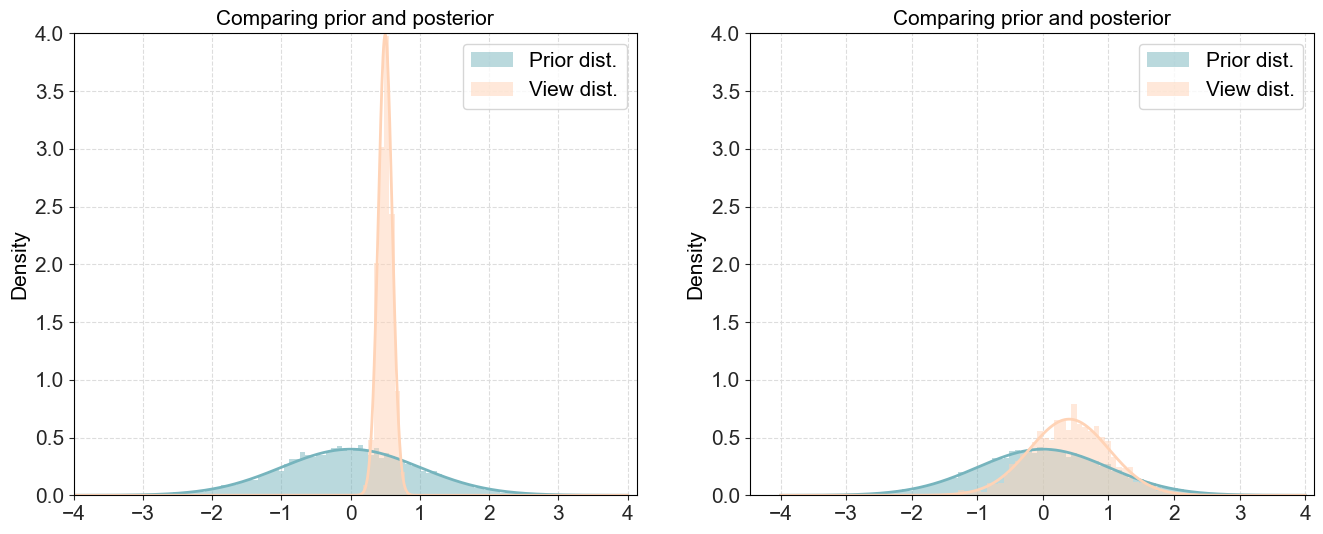

In [18]:
fig, ax = plt.subplots(1,2, figsize=(16,6))

for i in range(2):
    ax[i].hist(prior_data[:, i], bins=100, density=True, alpha=0.5, label="Prior dist.",
               color=default_colors['cyan'])
    ax[i].plot(x_values, stats.norm.pdf(x_values, loc=mu[i], scale=np.sqrt(cov_mat[i, i])),
               color=default_colors['cyan']);
    ax[i].hist(prior_data[:, i], bins=100, weights=p_tilde, density=True, alpha=0.5, label="View dist.",
               color=default_colors['orange']);
    ax[i].plot(x_values, stats.norm.pdf(x_values, loc=mu_tilde[i], scale=np.sqrt(sigma_tilde[i, i])),
               color=default_colors['orange']);
    ax[i].set_title('Comparing prior and posterior'.format(i + 1), size=15)
    ax[i].set_ylabel('Density', size=15);
    ax[i].legend(fontsize=15);
    ax[i].set_ylim([0.0, 4.0]);

if False:
    plt.tight_layout()
    plt.savefig('fully_flexible_views_bivariate_normal_numerical.png', dpi=300)

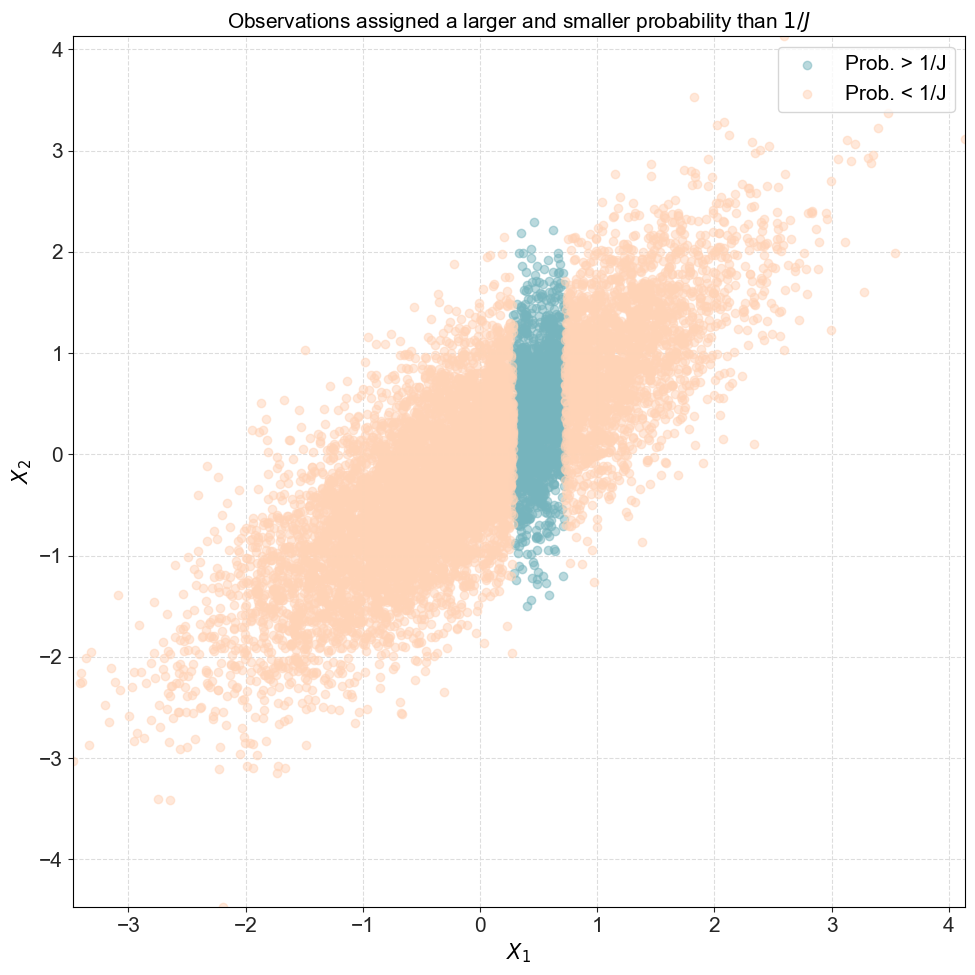

In [19]:
indicator = (p_tilde > 1.0 / num_sim)

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(prior_data[indicator, 0], prior_data[indicator, 1], alpha=0.5,
            color=default_colors['cyan'], label="Prob. > 1/J")
ax.scatter(prior_data[~indicator, 0], prior_data[~indicator, 1], alpha=0.5,
            color=default_colors['orange'], label="Prob. < 1/J")

ax.legend(fontsize=15); 
ax.set_xlabel('$X_1$', size=15);
ax.set_ylabel('$X_2$', size=15);
ax.set_title('Observations assigned a larger and smaller probability than $1 / J$', size=15);

if True:
    plt.tight_layout()
    plt.savefig('fully_flexible_views_bivariate_normal_numerical_scatter_plot.png', dpi=300)

### The codelib implementation for easy use

In [20]:
"""
Class that implements the above method
"""

mean_view = MeanView('eq', prior_data[:, 0], 0.5)
vol_view = VolatilityView('eq', prior_data[:, 0], 0.5, 0.1)

all_views = [mean_view, vol_view]

view_solver = ProbabilitySolver(init_probs, all_views)
view_probs = view_solver.minimize_entropy()

## Example: The Vasicek short rate model

In this example, we simulate 10,000 realizations from a Vasicek short rate model and apply views. First, the Vasicek short rate model specifies the short rate as 

$$
dr_{t}= \kappa (\theta - r_{t})dt+\beta dz_{t}
$$

For simulating the Vasicek short rate model, the following formula can handily be applied ($s>t$)

$$
\text{E}_t [r_s] = \theta + (r_t - \theta) e^{- \kappa (s-t)}
$$

and 

$$
\text{Var}_t [r_s] = \frac{\beta^2}{2 \kappa} \left(1 - e^{- 2 \kappa (s-t)} \right)
$$



In [21]:
def simulate_vasicek(initial_short_rate: float, kappa: float, theta: float, beta: float, horizon: float, 
                     dt: float=1.0/12, num_sim: int=10000) -> np.ndarray:
    """
    simulates short rate processes in a vasicek setting until a given horizon 
    
    Parameters
    ----------
    initial_short_rate:
        initial short rate
    kappa: 
        speed of mean reversion.
    theta: 
        long term mean of the short rate.
    dt:
        increments in time
    horizon:
        time until maturity/expiry (horizon).
    num_sim:
        number of simulations.
    
    Returns
    -------
    np.ndarray
        Array of simulated short rates. 
        
    """
    std_rates = np.sqrt(beta**2 / (2 * kappa) * (1 - np.exp(-2 * kappa * dt)))
    
    num_periods = int(horizon / dt)
    short_rates = np.empty((num_sim, num_periods + 1))
    short_rates[:, 0] = initial_short_rate
    
    error_terms = np.random.normal(scale=std_rates, size=(num_sim, num_periods))
    
    for i in range(1, num_periods + 1): 
        
        short_rates[:, i] = theta + (short_rates[:, i - 1] - theta) * np.exp(-kappa * dt) + error_terms[:, i - 1]
    
    return short_rates


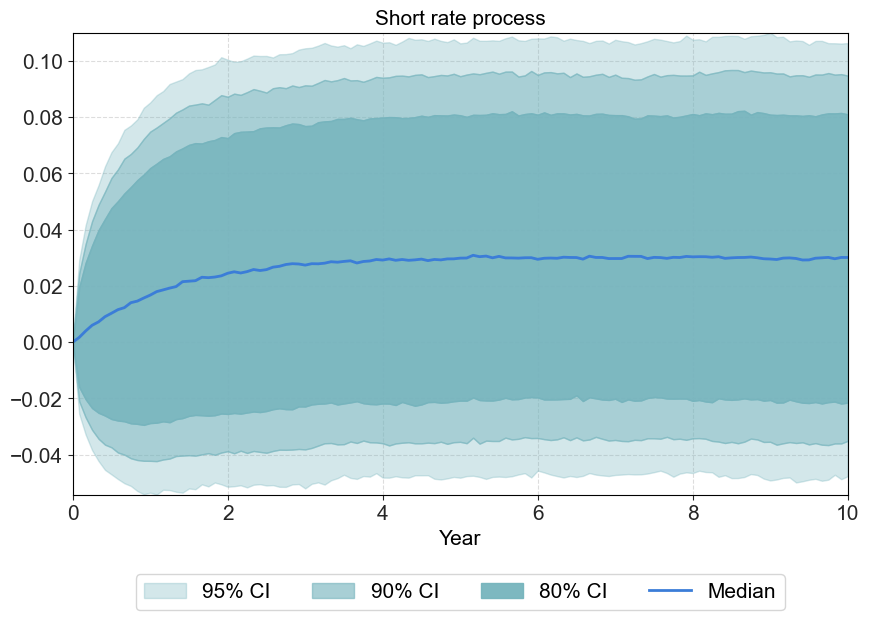

In [22]:
short_rates = simulate_vasicek(0.0, kappa=0.8, theta=0.03, beta=0.05, horizon=10, dt=1.0/12.0, num_sim=10000)
time_points = np.arange(0, 10.01, 1.0/12.0)

# calculate percentiles
percentiles = np.percentile(short_rates, [2.5, 5, 10, 50, 90, 95, 97.5], axis=0)

"""
Plot fan chart
"""

fig, ax = plt.subplots(figsize=(10, 6))

fan_chart(time_points,
          percentiles,
          color=default_colors['cyan'],
          color_median=default_colors['dark_blue'],
          labels=['95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax)

ax.set_xlabel("Year", size=15)
ax.set_title("Short rate process", size=15)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=15);

In [23]:
"""
Implement views on short rate
"""

mean_view_1y = MeanView('eq', short_rates[:, 13], 0.0)
mean_view_2y = MeanView('eq', short_rates[:, 25], 0.0)
mean_view_3y = MeanView('eq', short_rates[:, 37], 0.0)
mean_view_4y = MeanView('eq', short_rates[:, 49], 0.0)
mean_view_5y = MeanView('eq', short_rates[:, 61], 0.0)

all_views = [mean_view_1y, mean_view_2y, mean_view_3y, mean_view_4y, mean_view_5y]

view_solver = ProbabilitySolver(init_probs, all_views)
view_probs = view_solver.minimize_entropy()

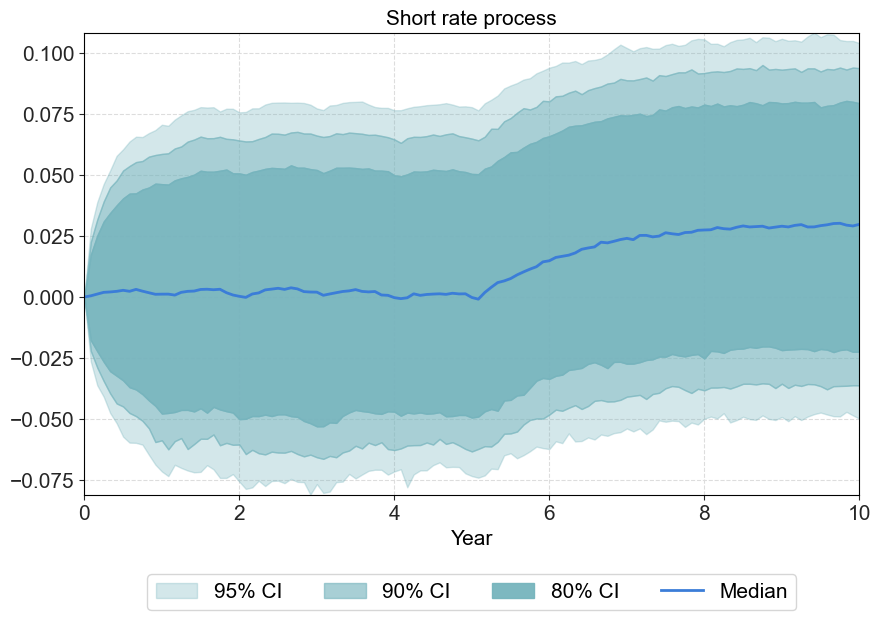

In [24]:
# calculate percentiles (see function in repository)
percentiles = weighted_percentile(short_rates, p=[0.025, 0.05, 0.10, 0.50, 0.90, 0.95, 0.975], probs=view_probs)

"""
Plot fan chart
"""

fig, ax = plt.subplots(figsize=(10, 6))

fan_chart(time_points,
          percentiles,
          color=default_colors['cyan'],
          color_median=default_colors['dark_blue'],
          labels=['95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax)

ax.set_xlabel("Year", size=15)
ax.set_title("Short rate process", size=15)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=15);

## Effective sample size entropy

Even though we minimize the relative entropy when we solve for a specific view, we will always incur a cost in the form of fewer effective scenarios in our weighted distribution (relative to our prior distribution). Generally, this cost will increase as our view diverges from the original distribution. If we want to use our weighted distribution as a stochastic model (e.g. for pricing and evaluation of investment strategies), it is important that we do not reduce the number of effective scenarios too much, as this increases the estimation uncertainty, everything else held equal. 

To evaluate the number of effective scenarios, [Attilio Meucci (2012), Effective Number of Scenarios in Fully Flexible Probabilities](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1971808), proposes the effective sample size entropy as a measure to evaluate the effect our view has on a given distribution. 

The measure can be calculated absolutely:

$$
\hat{J} = e^{-\sum_{j=1}^J p_j \ln p_j}
$$

and relatively:

$$
\frac{\hat{J}}{J}
$$

Here $\hat{J}$ gives us the number of effective scenarios, and $\frac{\hat{J}}{J}$ gives us the proportion of effective scenarios among all scenarios. The calculation of these metrics using the Vasicek-simulation can be seen below.

In [25]:
effective_sample_size_entropy(view_probs)

np.float64(5645.674403688797)

In [26]:
effective_sample_size_entropy(view_probs, True)

np.float64(0.5645674403688796)

## Literature 

[Attilio Meucci (2010), Fully Flexible Views: Theory and Practice](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1213325)

[Attilio Meucci (2012), Effective Number of Scenarios in Fully Flexible Probabilities](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1971808)